In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm, ensemble
from sklearn.ensemble import AdaBoostRegressor
import time
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import ShuffleSplit
pd.options.mode.chained_assignment = None

weather = pd.read_csv('data/weather.csv')
pallet_history = pd.read_csv('data/Pallet_history_Gold_Spike.csv')
inbound = pd.read_csv('data/inbound_loads.csv')
outbound = pd.read_csv('data/outbound_laods.csv')
demand = pd.read_csv('data/demand_kWtrain_val.csv')

In [2]:
#################
# Preprocess inbound csv:
#################
print('\n #####\nInbound: \n ##### \n')
inbound_post = inbound[inbound.carrier_code != 'CANCEL']
inbound_post = inbound[inbound.carrier_code != '']

inbound_post['truck_signin_datetime'] = pd.to_datetime(inbound_post['truck_signin_datetime'])

# Compute delta times
inbound_load_time = pd.to_datetime(inbound_post['load_finish_datetime']) - pd.to_datetime(inbound_post['load_start_datetime'])
inbound_truck_time = pd.to_datetime(inbound_post['truck_signin_datetime']) - pd.to_datetime(inbound_post['signout_datetime'])

# Drop unnecessary columns
inbound_post = inbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
inbound_post['load_time'] = inbound_load_time
inbound_post['truck_time'] = inbound_truck_time

print(inbound_post.columns)

inbound_post['load_time'] = inbound_post['load_time'].dt.seconds
inbound_post['truck_time'] = inbound_post['truck_time'].dt.seconds

print('With NaN:', inbound_post.shape)

# Drop rows with >0 NaN values
inbound_post_nan = inbound_post.dropna().reset_index(drop=True)

print('Without NaN:', inbound_post_nan.shape)

#################
# Preprocess outbound csv:
#################
print('\n #####\nOutbound: \n ##### \n')
outbound_post = outbound[outbound.carrier_code != 'CANCEL']
outbound_post = outbound[outbound.carrier_code != 'VOID']
outbound_post = outbound[outbound.carrier_code != '']

outbound_post['truck_signin_datetime'] = pd.to_datetime(outbound_post['truck_signin_datetime'])

# Compute delta times
outbound_load_time = pd.to_datetime(outbound_post['load_finish_datetime']) - pd.to_datetime(outbound_post['load_start_datetime'])
outbound_truck_time = pd.to_datetime(outbound_post['truck_signin_datetime']) - pd.to_datetime(outbound_post['signout_datetime'])

# Drop unnecessary columns
outbound_post = outbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
outbound_post['load_time'] = outbound_load_time
outbound_post['truck_time'] = outbound_truck_time

print(outbound_post.columns)

outbound_post['load_time'] = outbound_post['load_time'].dt.seconds
outbound_post['truck_time'] = outbound_post['truck_time'].dt.seconds

print('With NaN:', outbound_post.shape)

# Drop rows with >0 NaN values
outbound_post_nan = outbound_post.dropna().reset_index(drop=True)

print('Without NaN:', outbound_post_nan.shape)

#################
# Preprocess demand csv:
#################
print('\n #####\nDemand:  \n ##### \n')

demand['datetime_local'] = pd.to_datetime(demand['datetime_local'])

# How to split time series:
# https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

end_known_idx = demand[demand.demand_kW > 1].index[-1]
train_val_split = 0.7 # 70% train, 30% val
end_train_idx = int((train_val_split) * end_known_idx)
demand_train = demand.loc[0:end_train_idx-1]
demand_val = demand.loc[end_train_idx:end_known_idx]
demand_test = demand.iloc[end_known_idx+1:-2]

print('Full dataset:', demand.shape)
print('Answers known until index: ', end_known_idx)
print(f'Training set, {int(train_val_split*100)}%:', demand_train.shape)
print(f'Validation set, {int(100-train_val_split*100)}%:', demand_val.shape)
print('Test set', demand_test.shape)

#################
# Preprocess weather csv:
#################
print('\n #####\nWeather:  \n ##### \n')

weather_post = weather.copy()
UTC6 = pd.to_datetime(weather_post['datetime_UTC']) - pd.Timedelta(hours=6)
weather_post['datetime_america'] = UTC6
weather_post = weather_post.drop('datetime_UTC', axis=1)
weather_post = weather_post.drop(['datetime', 'hour', 'Unnamed: 0'], axis=1)

print(weather_post.head())
print(weather_post.columns)
print(weather_post.shape)



 #####
Inbound: 
 ##### 

Index(['front_temperature', 'middle_temperature', 'back_temperature',
       'net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (56146, 9)
Without NaN: (8761, 9)

 #####
Outbound: 
 ##### 

Index(['net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (112363, 6)
Without NaN: (96704, 6)

 #####
Demand:  
 ##### 

Full dataset: (365349, 3)
Answers known until index:  273987
Training set, 70%: (191790, 3)
Validation set, 30%: (82198, 3)
Test set (91359, 3)

 #####
Weather:  
 ##### 

   Relative Humidity  Temperature    datetime_america
0              50.37         53.6 2018-12-31 18:00:00
1              50.37         53.6 2018-12-31 18:05:00
2              50.37         53.6 2018-12-31 18:10:00
3              50.37         53.6 2018-12-31 18:15:00
4              50.37         53.6 2018-12-31

In [3]:
# Combine weather and demand data to train, val, and test sets

weather_post.sort_values("datetime_america", inplace=True)
demand_test.sort_values("datetime_local", inplace=True)
print("weather", weather_post.shape, '\n')
print("demand_train", demand_train.shape)
print("demand_val", demand_val.shape)
print("demand_test", demand_test.shape, '\n')
demand_weather_train = pd.merge_asof(demand_train, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')
demand_weather_val = pd.merge_asof(demand_val, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')
demand_weather_test = pd.merge_asof(demand_test, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')

# demand_weather_train.set_index('datetime_local', inplace=True)
demand_weather_train = demand_weather_train.drop(['Unnamed: 0','datetime_america'], axis=1)
# demand_weather_val.set_index('datetime_local', inplace=True)
demand_weather_val = demand_weather_val.drop(['Unnamed: 0','datetime_america'], axis=1)
# demand_weather_test.set_index('datetime_local', inplace=True)
demand_weather_test = demand_weather_test.drop(['Unnamed: 0','datetime_america'], axis=1)

print("train merged", demand_weather_train.shape)
print("val merged", demand_weather_val.shape)
print("test merged", demand_weather_test.shape)

demand_weather_train.head()

weather (328242, 3) 

demand_train (191790, 3)
demand_val (82198, 3)
demand_test (91359, 3) 

train merged (191790, 4)
val merged (82198, 4)
test merged (91359, 4)


,datetime_local,demand_kW,Relative Humidity,Temperature
0,2018-12-31 21:15:00,2064.101392,61.27,46.4
1,2018-12-31 21:30:00,1874.002081,61.27,46.4
2,2018-12-31 21:45:00,1988.168511,65.60,44.6
3,2018-12-31 22:00:00,2022.795943,65.60,44.6
4,2018-12-31 22:15:00,1986.981872,65.60,44.6


In [4]:
# Merging inbound with the above demand/weather dataset. Maximum 15 minutes difference in order to merge.
# Results in NaN and NaT where > 15 mins difference.
inbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("train pre", demand_weather_train.shape)
print("val pre", demand_weather_val.shape)
print("test pre", demand_weather_test.shape, '\n')

demand_inbound_merge_train = pd.merge_asof(demand_weather_train, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_val = pd.merge_asof(demand_weather_val, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_test = pd.merge_asof(demand_weather_test, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))

demand_inbound_merge_train = demand_inbound_merge_train.drop(['truck_signin_datetime'], axis=1)
# demand_inbound_merge_train.set_index('datetime_local', inplace=True)
demand_inbound_merge_val = demand_inbound_merge_val.drop(['truck_signin_datetime'], axis=1)
# demand_inbound_merge_val.set_index('datetime_local', inplace=True)
demand_inbound_merge_test = demand_inbound_merge_test.drop(['truck_signin_datetime'], axis=1)
# demand_inbound_merge_test.set_index('datetime_local', inplace=True)

print("train post", demand_inbound_merge_train.shape)
print("val post", demand_inbound_merge_val.shape)
print("test post", demand_inbound_merge_test.shape)

demand_inbound_merge_train.head()

train pre (191790, 4)
val pre (82198, 4)
test pre (91359, 4) 

train post (191790, 12)
val post (82198, 12)
test post (91359, 12)


,datetime_local,demand_kW,Relative Humidity,Temperature,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,load_time,truck_time
0,2018-12-31 21:15:00,2064.101392,61.27,46.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-31 21:30:00,1874.002081,61.27,46.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-31 21:45:00,1988.168511,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-31 22:00:00,2022.795943,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12-31 22:15:00,1986.981872,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Merging outbound with the above demand/weather/inbound dataset. Maximum 15 minutes difference in order to merge.
# Results in NaN and NaT where > 15 mins difference.
outbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("train pre", demand_inbound_merge_train.shape)
print("val pre", demand_inbound_merge_val.shape)
print("test pre", demand_inbound_merge_test.shape, '\n')

demand_inbound_merge_train = pd.merge_asof(demand_inbound_merge_train, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_val = pd.merge_asof(demand_inbound_merge_val, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_test = pd.merge_asof(demand_inbound_merge_test, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))

demand_inbound_merge_train = demand_inbound_merge_train.drop(['truck_signin_datetime'], axis=1)
demand_inbound_merge_train.set_index('datetime_local', inplace=True)
demand_inbound_merge_val = demand_inbound_merge_val.drop(['truck_signin_datetime'], axis=1)
demand_inbound_merge_val.set_index('datetime_local', inplace=True)
demand_inbound_merge_test = demand_inbound_merge_test.drop(['truck_signin_datetime'], axis=1)
demand_inbound_merge_test.set_index('datetime_local', inplace=True)

demand_inbound_merge_train.index = (demand_inbound_merge_train.index - demand_inbound_merge_train.index[0]).seconds/60
demand_inbound_merge_val.index = (demand_inbound_merge_val.index - demand_inbound_merge_val.index[0]).seconds/60
demand_inbound_merge_test.index = (demand_inbound_merge_test.index - demand_inbound_merge_test.index[0]).seconds/60

print("train post", demand_inbound_merge_train.shape)
print("val post", demand_inbound_merge_val.shape)
print("test post", demand_inbound_merge_test.shape)

demand_inbound_merge_train.head()

train pre (191790, 12)
val pre (82198, 12)
test pre (91359, 12) 

train post (191790, 16)
val post (82198, 16)
test post (91359, 16)


,demand_kW,Relative Humidity,Temperature,front_temperature,middle_temperature,back_temperature,net_weight_in,case_quantity_in,pallet_count_in,load_time_in,truck_time_in,net_weight_out,case_quantity_out,pallet_count_out,load_time_out,truck_time_out
datetime_local,,,,,,,,,,,,,,,,
0.0,2064.101392,61.27,46.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15.0,1874.002081,61.27,46.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30.0,1988.168511,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45.0,2022.795943,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60.0,1986.981872,65.60,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we have three large dataframes with NaNs where the merges didnt match. Three dataframes: train, val, and test.

In [62]:
train = demand_inbound_merge_train
val = demand_inbound_merge_val
test = demand_inbound_merge_test

print('train:',train.shape)
print('val:',val.shape)
print('test:',test.shape)

test.info()


train: (191790, 16)
val: (82198, 16)
test: (91359, 16)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 91359 entries, 0.0 to 709.0
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand_kW           0 non-null      float64
 1   Relative Humidity   91271 non-null  float64
 2   Temperature         91294 non-null  float64
 3   front_temperature   0 non-null      float64
 4   middle_temperature  0 non-null      float64
 5   back_temperature    0 non-null      float64
 6   net_weight_in       0 non-null      float64
 7   case_quantity_in    0 non-null      float64
 8   pallet_count_in     0 non-null      float64
 9   load_time_in        0 non-null      float64
 10  truck_time_in       0 non-null      float64
 11  net_weight_out      57571 non-null  float64
 12  case_quantity_out   57571 non-null  float64
 13  pallet_count_out    57571 non-null  float64
 14  load_time_out       57571 non-null  float64

In [59]:
# Split the data into training and test sets
X_train = train.drop('demand_kW', axis=1)
y_train = np.array(train['demand_kW']).ravel()

X_val = val.drop('demand_kW', axis=1)
y_val = np.array(val['demand_kW']).ravel()

X_test = test.drop('demand_kW', axis=1)

# Fill NaNs with mean
X_train['Relative Humidity'].fillna(value=np.mean(X_train['Relative Humidity']), inplace=True)
X_val['Relative Humidity'].fillna(value=np.mean(X_val['Relative Humidity']), inplace=True)
X_test['Relative Humidity'].fillna(value=np.mean(X_test['Relative Humidity']), inplace=True)

X_train['Temperature'].fillna(value=np.mean(X_train['Temperature']), inplace=True)
X_val['Temperature'].fillna(value=np.mean(X_val['Temperature']), inplace=True)
X_test['Temperature'].fillna(value=np.mean(X_test['Temperature']), inplace=True)

# Setting X_val and X_test temp to X_train means, because they have 0 measurements for these
X_train['front_temperature'].fillna(value=np.mean(X_train['front_temperature']), inplace=True)
X_val['front_temperature'].fillna(value=np.mean(X_train['front_temperature']), inplace=True)
X_test['front_temperature'].fillna(value=np.mean(X_train['front_temperature']), inplace=True)

X_train['middle_temperature'].fillna(value=np.mean(X_train['middle_temperature']), inplace=True)
X_val['middle_temperature'].fillna(value=np.mean(X_train['middle_temperature']), inplace=True)
X_test['middle_temperature'].fillna(value=np.mean(X_train['middle_temperature']), inplace=True)

X_train['back_temperature'].fillna(value=np.mean(X_train['back_temperature']), inplace=True)
X_val['back_temperature'].fillna(value=np.mean(X_train['back_temperature']), inplace=True)
X_test['back_temperature'].fillna(value=np.mean(X_train['back_temperature']), inplace=True)

# Fill NaNs with 0
X_train['net_weight_in'].fillna(value=0, inplace=True)
X_val['net_weight_in'].fillna(value=0, inplace=True)
X_test['net_weight_in'].fillna(value=0, inplace=True)

X_train['case_quantity_in'].fillna(value=0, inplace=True)
X_val['case_quantity_in'].fillna(value=0, inplace=True)
X_test['case_quantity_in'].fillna(value=0, inplace=True)

X_train['pallet_count_in'].fillna(value=0, inplace=True)
X_val['pallet_count_in'].fillna(value=0, inplace=True)
X_test['pallet_count_in'].fillna(value=0, inplace=True)

X_train['load_time_in'].fillna(value=0, inplace=True)
X_val['load_time_in'].fillna(value=0, inplace=True)
X_test['load_time_in'].fillna(value=0, inplace=True)

X_train['truck_time_in'].fillna(value=0, inplace=True)
X_val['truck_time_in'].fillna(value=0, inplace=True)
X_test['truck_time_in'].fillna(value=0, inplace=True)

X_train['net_weight_out'].fillna(value=0, inplace=True)
X_val['net_weight_out'].fillna(value=0, inplace=True)
X_test['net_weight_out'].fillna(value=0, inplace=True)

X_train['case_quantity_out'].fillna(value=0, inplace=True)
X_val['case_quantity_out'].fillna(value=0, inplace=True)
X_test['case_quantity_out'].fillna(value=0, inplace=True)

X_train['pallet_count_out'].fillna(value=0, inplace=True)
X_val['pallet_count_out'].fillna(value=0, inplace=True)
X_test['pallet_count_out'].fillna(value=0, inplace=True)

X_train['load_time_out'].fillna(value=0, inplace=True)
X_val['load_time_out'].fillna(value=0, inplace=True)
X_test['load_time_out'].fillna(value=0, inplace=True)

X_train['truck_time_out'].fillna(value=0, inplace=True)
X_val['truck_time_out'].fillna(value=0, inplace=True)
X_test['truck_time_out'].fillna(value=0, inplace=True)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

X_train.head()

(191790, 15)
(82198, 15)
(91359, 15)


,Relative Humidity,Temperature,front_temperature,middle_temperature,back_temperature,net_weight_in,case_quantity_in,pallet_count_in,load_time_in,truck_time_in,net_weight_out,case_quantity_out,pallet_count_out,load_time_out,truck_time_out
datetime_local,,,,,,,,,,,,,,,
0.0,61.27,46.4,1.828318,2.220084,2.37777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.0,61.27,46.4,1.828318,2.220084,2.37777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30.0,65.60,44.6,1.828318,2.220084,2.37777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45.0,65.60,44.6,1.828318,2.220084,2.37777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60.0,65.60,44.6,1.828318,2.220084,2.37777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Set up pipeline parameters
params = {
    "n_estimators": 500,
    "learning_rate": 1,
    "loss": "squared_error",
}

pipeline = ensemble.GradientBoostingRegressor(**params),
pipeline = pipeline[0]

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(pipeline.staged_predict(X_val)):
    test_score[i] = mean_squared_error(y_val, y_pred)

y_pred = np.array(list(pipeline.staged_predict(X_val)))[-1]
data = {'y_pred': y_pred,
        'y_val': y_val}
pd.DataFrame(data).to_csv('output/y_pred_val.csv', index=False)

mse = mean_squared_error(y_val, y_pred)
print('MSE val', mse)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title(f"Deviance on val \n mse = {mse}")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    pipeline.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

MSE val 113686.36462316984
score -0.6537840029974029
['Relative Humidity' 'Temperature' 'front_temperature'
 'middle_temperature' 'back_temperature' 'net_weight_in'
 'case_quantity_in' 'pallet_count_in' 'load_time_in' 'truck_time_in'
 'net_weight_out' 'case_quantity_out' 'pallet_count_out' 'load_time_out'
 'truck_time_out']


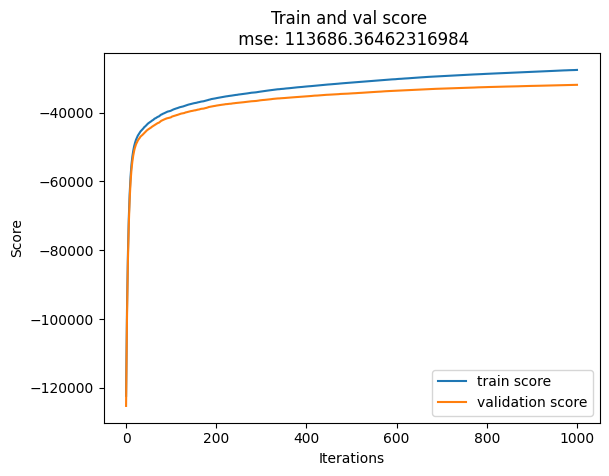

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Split the data into training and test sets
X_train = train.drop('demand_kW', axis=1)
y_train = np.array(train['demand_kW']).ravel()

X_val = val.drop('demand_kW', axis=1)
y_val = np.array(val['demand_kW']).ravel()

X_test = test.drop('demand_kW', axis=1)

clf = HistGradientBoostingRegressor(max_iter=1000, loss='squared_error', l2_regularization=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

data = {'y_pred': y_pred,
        'y_val': y_val}
pd.DataFrame(data).to_csv('y_pred_val.csv', index=False)

mse = mean_squared_error(y_val, y_pred)
print('MSE val', mse)
print('score', clf.score(X_val, y_val))
print(clf.feature_names_in_)

tr = clf.train_score_
vl = clf.validation_score_
x = np.arange(0, clf.n_iter_ + 1)
plt.plot(x, tr, label='train score')
plt.plot(x, vl, label='validation score')
plt.title(f'Train and val score \n mse: {mse}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.show()

